# Step #1 Load the Data

In [1]:
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta # Date Functions
from pandas.plotting import register_matplotlib_converters # Adds plotting functions for calender dates
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for recurrent and regular densely-connected layers
import tensorflow as tf

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Taking a look at the shape of the dataset
print(df.shape)
df.head(5)

Tensorflow Version: 2.5.0
Num GPUs: 0
[*********************100%***********************]  1 of 1 completed
(3105, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000


# Step #2 Explore the Data

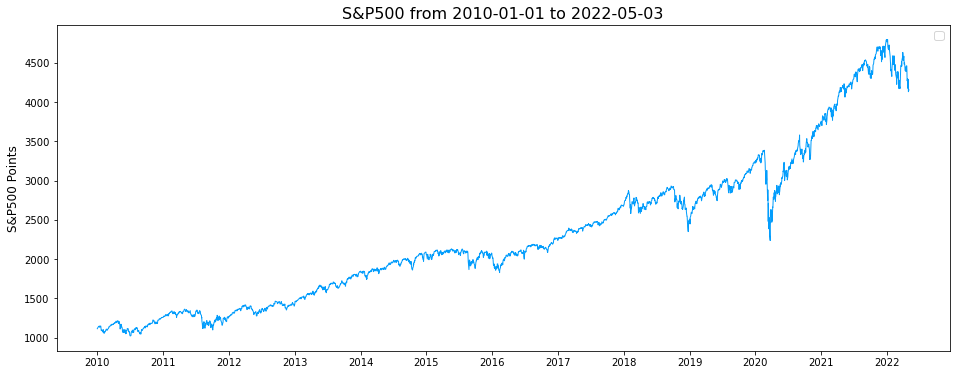

In [2]:
# Plotting the data
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df.index
y = df['Close']
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ start_date + ' to ' + end_date, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('S&P500 Points', fontsize=12)
plt.show()

# Step #3 Preprocess the Data

In [4]:
# Feature Selection - Only Close Data
train_df = df.filter(['Close'])
data_unscaled = train_df.values

# Get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(len(data_unscaled) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [5]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = train_df.columns.get_loc("Close")
print(index_Close)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0
(2419, 50, 1) (2419,)
(617, 50, 1) (617,)
0.5251591107121002
0.5251591107121002


# Step #4 Design the Model Architecture

In [6]:
# Configure the neural network model
model = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step #5 Train the Model

In [7]:
# Training the model
model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
152/152 [==============================] - 4s 28ms/step - loss: 0.0043
Epoch 2/25
152/152 [==============================] - 4s 25ms/step - loss: 1.3046e-04
Epoch 3/25
152/152 [==============================] - 4s 26ms/step - loss: 1.3556e-04
Epoch 4/25
152/152 [==============================] - 4s 25ms/step - loss: 1.2935e-04
Epoch 5/25
152/152 [==============================] - 4s 24ms/step - loss: 1.2647e-04
Epoch 6/25
152/152 [==============================] - 4s 24ms/step - loss: 1.3631e-04
Epoch 7/25
152/152 [==============================] - 4s 24ms/step - loss: 1.1472e-04
Epoch 8/25
152/152 [==============================] - 4s 24ms/step - loss: 1.1044e-04
Epoch 9/25
152/152 [==============================] - 4s 24ms/step - loss: 1.0936e-04
Epoch 10/25
152/152 [==============================] - 4s 25ms/step - loss: 9.7060e-05
Epoch 11/25
152/152 [==============================] - 4s 25ms/step - loss: 1.1103e-04
Epoch 12/25
152/152 [==============================] - 4

# Step #6 Make Predictions

In [8]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

# Step #7 Evaluate Model Performance

In [9]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 50.09
Mean Absolute Percentage Error (MAPE): 1.38 %
Median Absolute Percentage Error (MDAPE): 1.04 %


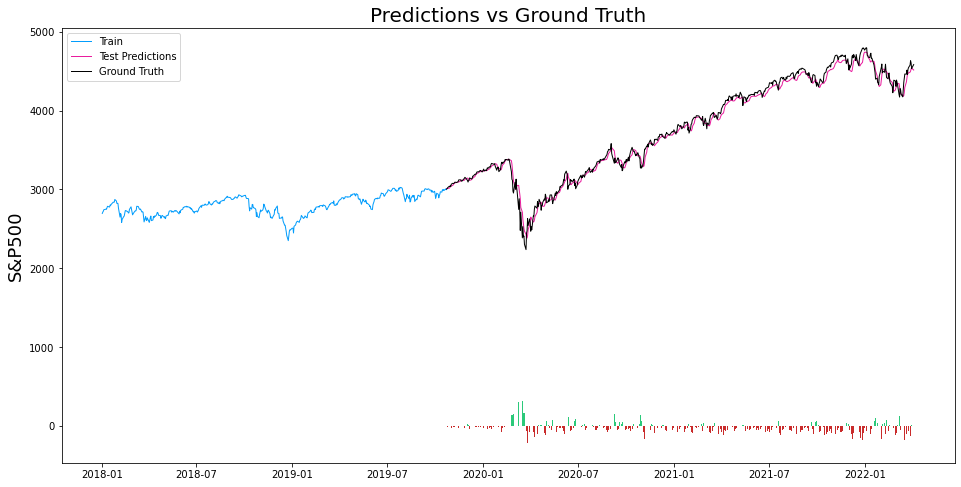

In [10]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = train_df[:train_data_length + 1]
valid = train_df[train_data_length:]
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax = plt.subplots(figsize=(16, 8), sharex=True)

plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(train["Close"], color="#039dfc", linewidth=1.0)
plt.plot(valid["Predictions"], color="#E91D9E", linewidth=1.0)
plt.plot(valid["Close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
# ax.fill_between(yt.index, 0, yt["Close"], color="#b9e1fa")
# ax.fill_between(yv.index, 0, yv["Predictions"], color="#F0845C")
# ax.fill_between(yv.index, yv["Close"], yv["Predictions"], color="grey") 

# Create the bar plot with the differences
valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

In [11]:
# Show the valid and predicted prices
dif = valid['Close'] - valid['Predictions']
valid.insert(2, 'Difference', dif, True)
valid.tail(5)

,Close,Difference,Difference,Predictions,diff_color
Date,,,,,
2022-03-29,4631.600098,-130.984863,130.984863,4500.615234,#C92B2B
2022-03-30,4602.450195,-75.163574,75.163574,4527.286621,#C92B2B
2022-03-31,4530.410156,12.969727,-12.969727,4543.379883,#2BC97A
2022-04-01,4545.859863,-14.790039,14.790039,4531.069824,#C92B2B
2022-04-04,4582.640137,-69.082031,69.082031,4513.558105,#C92B2B


# Step #8 Predict Next Day's Price

In [12]:
# Get fresh data
df_new = df.filter(['Close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled = mmscaler.transform(df_new[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

prefix = '+' if percent > 0 else ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({prefix}{percent}%)')

The close price for S&P500 at 2022-04-05 was 4582.64
The predicted close price is 4507.27001953125 (+1.64%)
